# Group
- Sofia MARCHIORETTO
- Alain Marcel DIKANDE SIMO
- Yhony MAMANI ARCE
- Juan Diego VIZCAINO SORIANO
- Juan Sebastian VELEZ ROJAS 

### Introduction

Data represents the percentage of mRNA relative to each gene $i$ measured in various enviromental conditions, at each of which corresponds a constant growth rate $\lambda$ (we assume to be in equilibrium exponential growth). We assume that all this mRNA will then be equally translated into proteins and therefore that we can treat the data as the fractions of the proteome that are relative to protein $i$. According to Scott et al., 2010 we can divide the proteome in classes: ribosome-affiliated "class R" with fraction $\phi_R$, "class Q" of regulated proteins with fraction $\phi_Q$ indipendent of the growth rate and "class P" of constitutively expressed protein with fraction $\phi_P$ dependent on the growth rate. We can then split the P class into classes C and A, with fraction $\phi_C$ and $\phi_A$, accounting respectively for proteins affiliated with catabolic processes and anabolic processes. The model then is as follows:

$$ \lambda(E) = \kappa_c(E) \phi_C(E) = \kappa_A(E) \phi_A(E) = \kappa_t(E) \left( \phi_R(E) - \phi_0 \right) $$
$$ \phi_A(E) + \phi_C(E) + \phi_R(E) = 1-\phi_Q = \phi_{max} $$

where E represents the environmental conditions.
Given that the fractions $\phi$ are relative to the total amount of proteins for each class we decide to group the genes $i \in {1,\dots,N}$ according to their functionalities $\alpha_i \in \{A, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X\}$ to obtain the percentage of proteome of a given functionality $\alpha$:

$$ \phi_{\alpha} = \sum_{i=1} ^N \phi_i \delta_{\alpha_i,\alpha} $$

We aim at identify one or multiple functionalities that belong to groups Q, R, A, C by analyzing their dependency with respect to $\lambda$.

### Import the Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
sns.set(style="whitegrid")
sns.set_theme()

### Import the Data, define functions

- `df`: Contains the gene abundance vs. the condition.
- `df1`: Contains the condition vs. growth rate and so on.
- `df2`: Contains the gene abundance vs. functionality and so on.

In [2]:
df = pd.read_csv('transcriptomics_fractions.csv')
df1 = pd.read_csv('samples_transcriptomics.csv', index_col='Unnamed: 0').set_index('Sample.ID')
df2 = pd.read_csv('Ecoli_gene_functional_annotations.csv', encoding = 'cp1252', index_col='Unnamed: 0')

Deleting empty Data in DataFrame `df2`

In [3]:
df_renamed = df.rename(columns={'Unnamed: 0': 'gene'})
df_T = df_renamed.set_index('gene')
df2_sorted = df2.dropna(subset=['gene']).sort_values(by='gene', ascending=True).reset_index(drop=True)
df2_s = df2_sorted.set_index('gene')

In [4]:
df_join = pd.merge(df2_s, df_T, left_index=True, right_index=True)

Separating by group **A-lim**, **C-lim** and **R-lim**

In [5]:
Alim = df_join.loc[:,:'a4_1'].sort_values(by='top_cog_functional_cat', ascending=True)
Clim = df_join.drop(df_join.columns[list(range(7,14)) + list(range(24, 35))], axis=1).sort_values(by='top_cog_functional_cat', ascending=True)
Rlim = df_join.drop(df_join.columns[7:24], axis=1).sort_values(by='top_cog_functional_cat', ascending=True)

Creating a function `ffunctionality(group, functionality, a ,b)` where the parameters passed to it are the `group` (**Alim**, **Clim** or **Rlim**), the `functionality` and the values by which it will be separated, where it is commented in the function for each group what values `a` and `b` take. This function basically separates the functionalities (`A`, `C`, etc.) for each group.

In [35]:
def ffunctionality(group, functionality, a ,b):
    """a, b =  0, 7 for Alim
    a, b =  7, 17 for Clim
    a, b =  17, 28 for Rlim """
    func = group['top_cog_functional_cat'].tolist()
    for raw in enumerate(func):
        group_func = group[group['top_cog_functional_cat']==str(functionality)]
        group_f= group_func.iloc[:,7:].T
        #group_f['Growth.rate']= list(df1['Growth.rate..1.h.'][a:b])
        group_f['Gene.sum'] = group_f.sum(axis=1)
        group_ff = group_f['Gene.sum']
    return pd.merge(df1[a:b][:], group_ff, left_index=True, right_index=True)

This function `Tcog_func(G_name, group, a, b)` separates the `functionality` of each `group` and stores them in a dictionary. Where the key is the group and the functionality (e.g. `Alim_A`, etc), and the value is the DataFrames with their respective characteristics.

In [7]:
def Tcog_func(G_name, group, a, b):
    func = list(dict.fromkeys(Alim['top_cog_functional_cat'].tolist()))
    df_dict = {}
    for i in func:
        df_result = ffunctionality(group, i, a, b)
        df_dict[f"{G_name}_{i}"] = df_result
        #print(f"{G_name}_{i}")
    return df_dict

Saving the dictionary for each `group`

In [8]:
ATcog_func_by_functionality = Tcog_func("Alim", Alim, 0, 7)

In [9]:
CTcog_func_by_functionality = Tcog_func("Clim", Clim, 7, 17)

In [10]:
RTcog_func_by_functionality = Tcog_func("Rlim", Rlim, 17, 28)

In [11]:
def generar_colores_hsv(n, saturacion=0.7, brillo=0.9):
    paso = 1.7 / n
    lista_colores = []
    for i in range(n):
        matiz = i * paso
        rgb = mcolors.hsv_to_rgb((matiz, saturacion, brillo))
        lista_colores.append(mcolors.to_hex(rgb))
    return lista_colores

This function `plot_group_join(group_cog)`, given the `group`, creates a plot with the `functionalities`, that is, on the x axis there is the `Growth Rate` and on the y axis there is the `Abundance`. It also fit them with a linear function.

In [12]:
def plot_group_join(group_cog):
    key_dic = list(group_cog.keys()) 
    
    palette = generar_colores_hsv(len(key_dic))

    fig, ax = plt.subplots(figsize=(11, 5))

    for idx, key in enumerate(key_dic):
        color = palette[idx] 

        sns.regplot(
            x=group_cog[key]['Growth.rate..1.h.'], 
            y=group_cog[key]['Gene.sum'], 
            ax=ax, 
            marker='o', 
            label=str(key[-1][0]), 
            scatter_kws={'s': 20, 'color': color},  
            line_kws={'color': color, 'linewidth': 1}, 
            ci=None  
        )

    ax.set_xlabel('Growth Rate', fontsize=13)
    ax.set_ylabel('Abundance', fontsize=13)
    ax.set_title(str(key_dic[0]).split('_')[0], fontsize=13)
    ax.legend(fontsize=6)
    plt.tight_layout()
    
    plt.show()

This function `plot_join_sep_by_func()` plots the three groups for each functionality and it also fit the data with a linear function.

In [47]:
import math
def plot_join_sep_by_func():
    groups_data = {
        'Alim': ATcog_func_by_functionality,
        'Clim': CTcog_func_by_functionality,
        'Rlim': RTcog_func_by_functionality
    }
    
    base_functionalities = sorted(list(df2['top_cog_functional_cat'].unique())) 
    
    palette = sns.color_palette("Set1", len(groups_data))
    
    cols_per_row = 3  
    total_plots = len(base_functionalities)
    rows = math.ceil(total_plots / cols_per_row)  

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))

    if rows == 1:
        axes = np.array([axes])  

    for idx, base_functionality in enumerate(base_functionalities):
        row = idx // cols_per_row
        col = idx % cols_per_row
        ax = axes[row, col]

        for j, (group, data) in enumerate(groups_data.items()):
            functionality_key = f"{group}_{base_functionality}"
            
            if functionality_key in data:
                color = palette[j]
                
                sns.regplot(
                    x=data[functionality_key]['Growth.rate..1.h.'], 
                    y=data[functionality_key]['Gene.sum'], 
                    ax=ax, 
                    marker='o', 
                    label=group, 
                    scatter_kws={'s': 50, 'color': color},  
                    line_kws={'color': color},  
                    ci=None  
                )
        
        ax.set_title(f'Functionality {base_functionality}', fontsize=14)
        ax.set_xlabel('Growth Rate', fontsize=12)
        ax.set_ylabel('Abundance', fontsize=12)
        ax.tick_params(axis='both', labelsize=10)
        ax.legend(fontsize=10)

    for idx in range(total_plots, rows * cols_per_row):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.show()

### Analysis and results
In the main equations given in the introduction, the parameters depending on $E$ could, in principle, all vary simultaneously. Experimental conditions instead are such that only one of the rates $\kappa_A$, $\kappa_C$, $\kappa_t$ changes and the other two are fixed. Therefore we analyze separetely the three experimental settings. For each we plot the fraction of proteome relative to each functionality $\alpha$ with respect to the growth rate.

## A-lim

In this experimental condition $\kappa_A$ is changed by varying the supplement provided to E. Coli, while $\kappa_t$ and $\kappa_C$ remains constant. Therefore our model predicts the following behavior:
$$ \phi_A = \phi_{max} - \phi_0 -\lambda \left(\frac{1}{\kappa_t}+\frac{1}{\kappa_C} \right) $$
$$ \phi_C = \frac{\lambda}{\kappa_C} $$
$$ \phi_R = \phi_0 + \frac{\lambda}{\kappa_t} $$
$$ \phi_Q = \text{const}$$

## C-lim

In this experimental condition $\kappa_C$ is changed, either by changing the supplement or the strain of E. Coli, while $\kappa_t$ and $\kappa_A$ remains constant. Therefore in our model:
$$ \phi_A = \frac{\lambda}{\kappa_A} $$
$$ \phi_C = \phi_{max} - \phi_0 -\lambda \left(\frac{1}{\kappa_t}+\frac{1}{\kappa_A} \right)$$
$$ \phi_R = \phi_0 + \frac{\lambda}{\kappa_t} $$
$$ \phi_Q = \text{const}$$

## R-lim

In this experimental condition $\kappa_t$ is changed by varying the amount of antibiotics provided to the culture, while $\kappa_C$ and $\kappa_A$ remains constant. Therefore:
$$ \phi_A = \frac{\lambda}{\kappa_A} $$
$$ \phi_C = \frac{\lambda}{\kappa_C} $$
$$ \phi_R = \phi_{max} - \lambda \left(\frac{1}{\kappa_A}+\frac{1}{\kappa_C} \right) $$
$$ \phi_Q = \text{const}$$

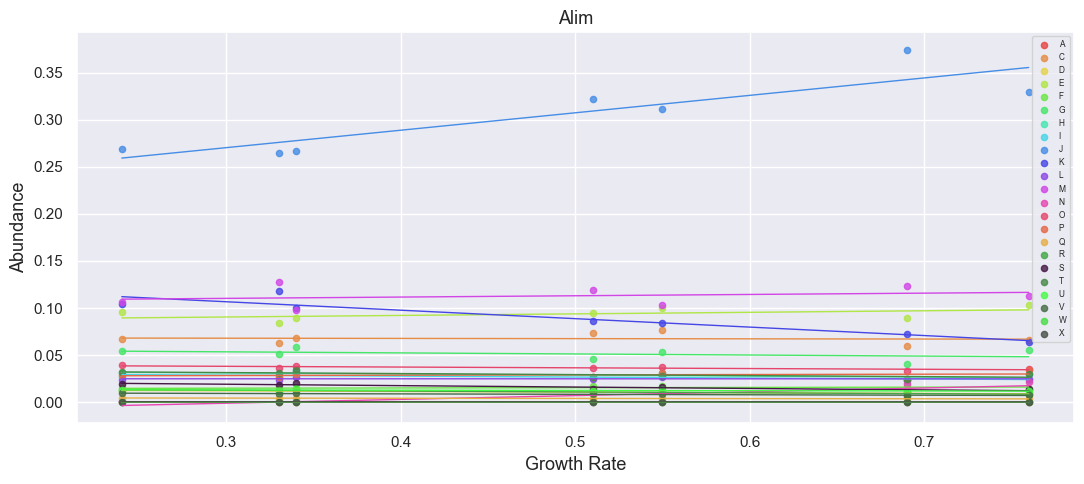

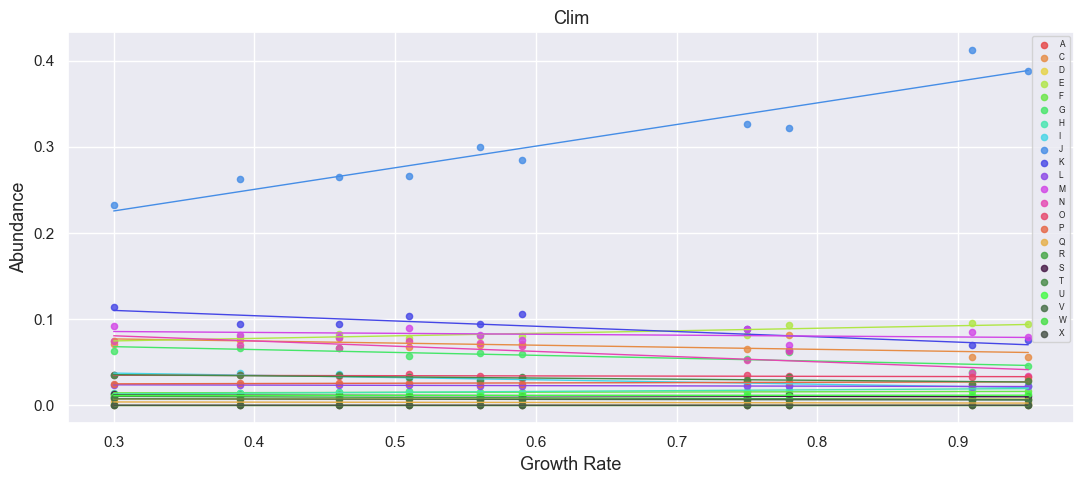

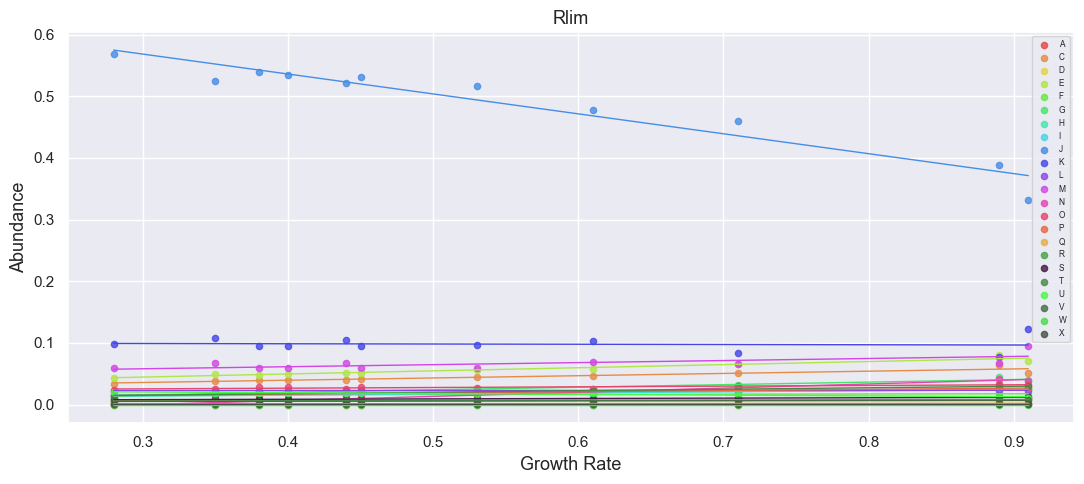

In [13]:
Alim_plot_fit = plot_group_join(ATcog_func_by_functionality)
Clim_plot_fit = plot_group_join(CTcog_func_by_functionality)
Rlim_plot_fit = plot_group_join(RTcog_func_by_functionality)

To reduce the crowding effect in the previous graphs we also plot the same data divided by functionality, to appreciate the variation of each fraction $\phi_\alpha$ on his own scale.

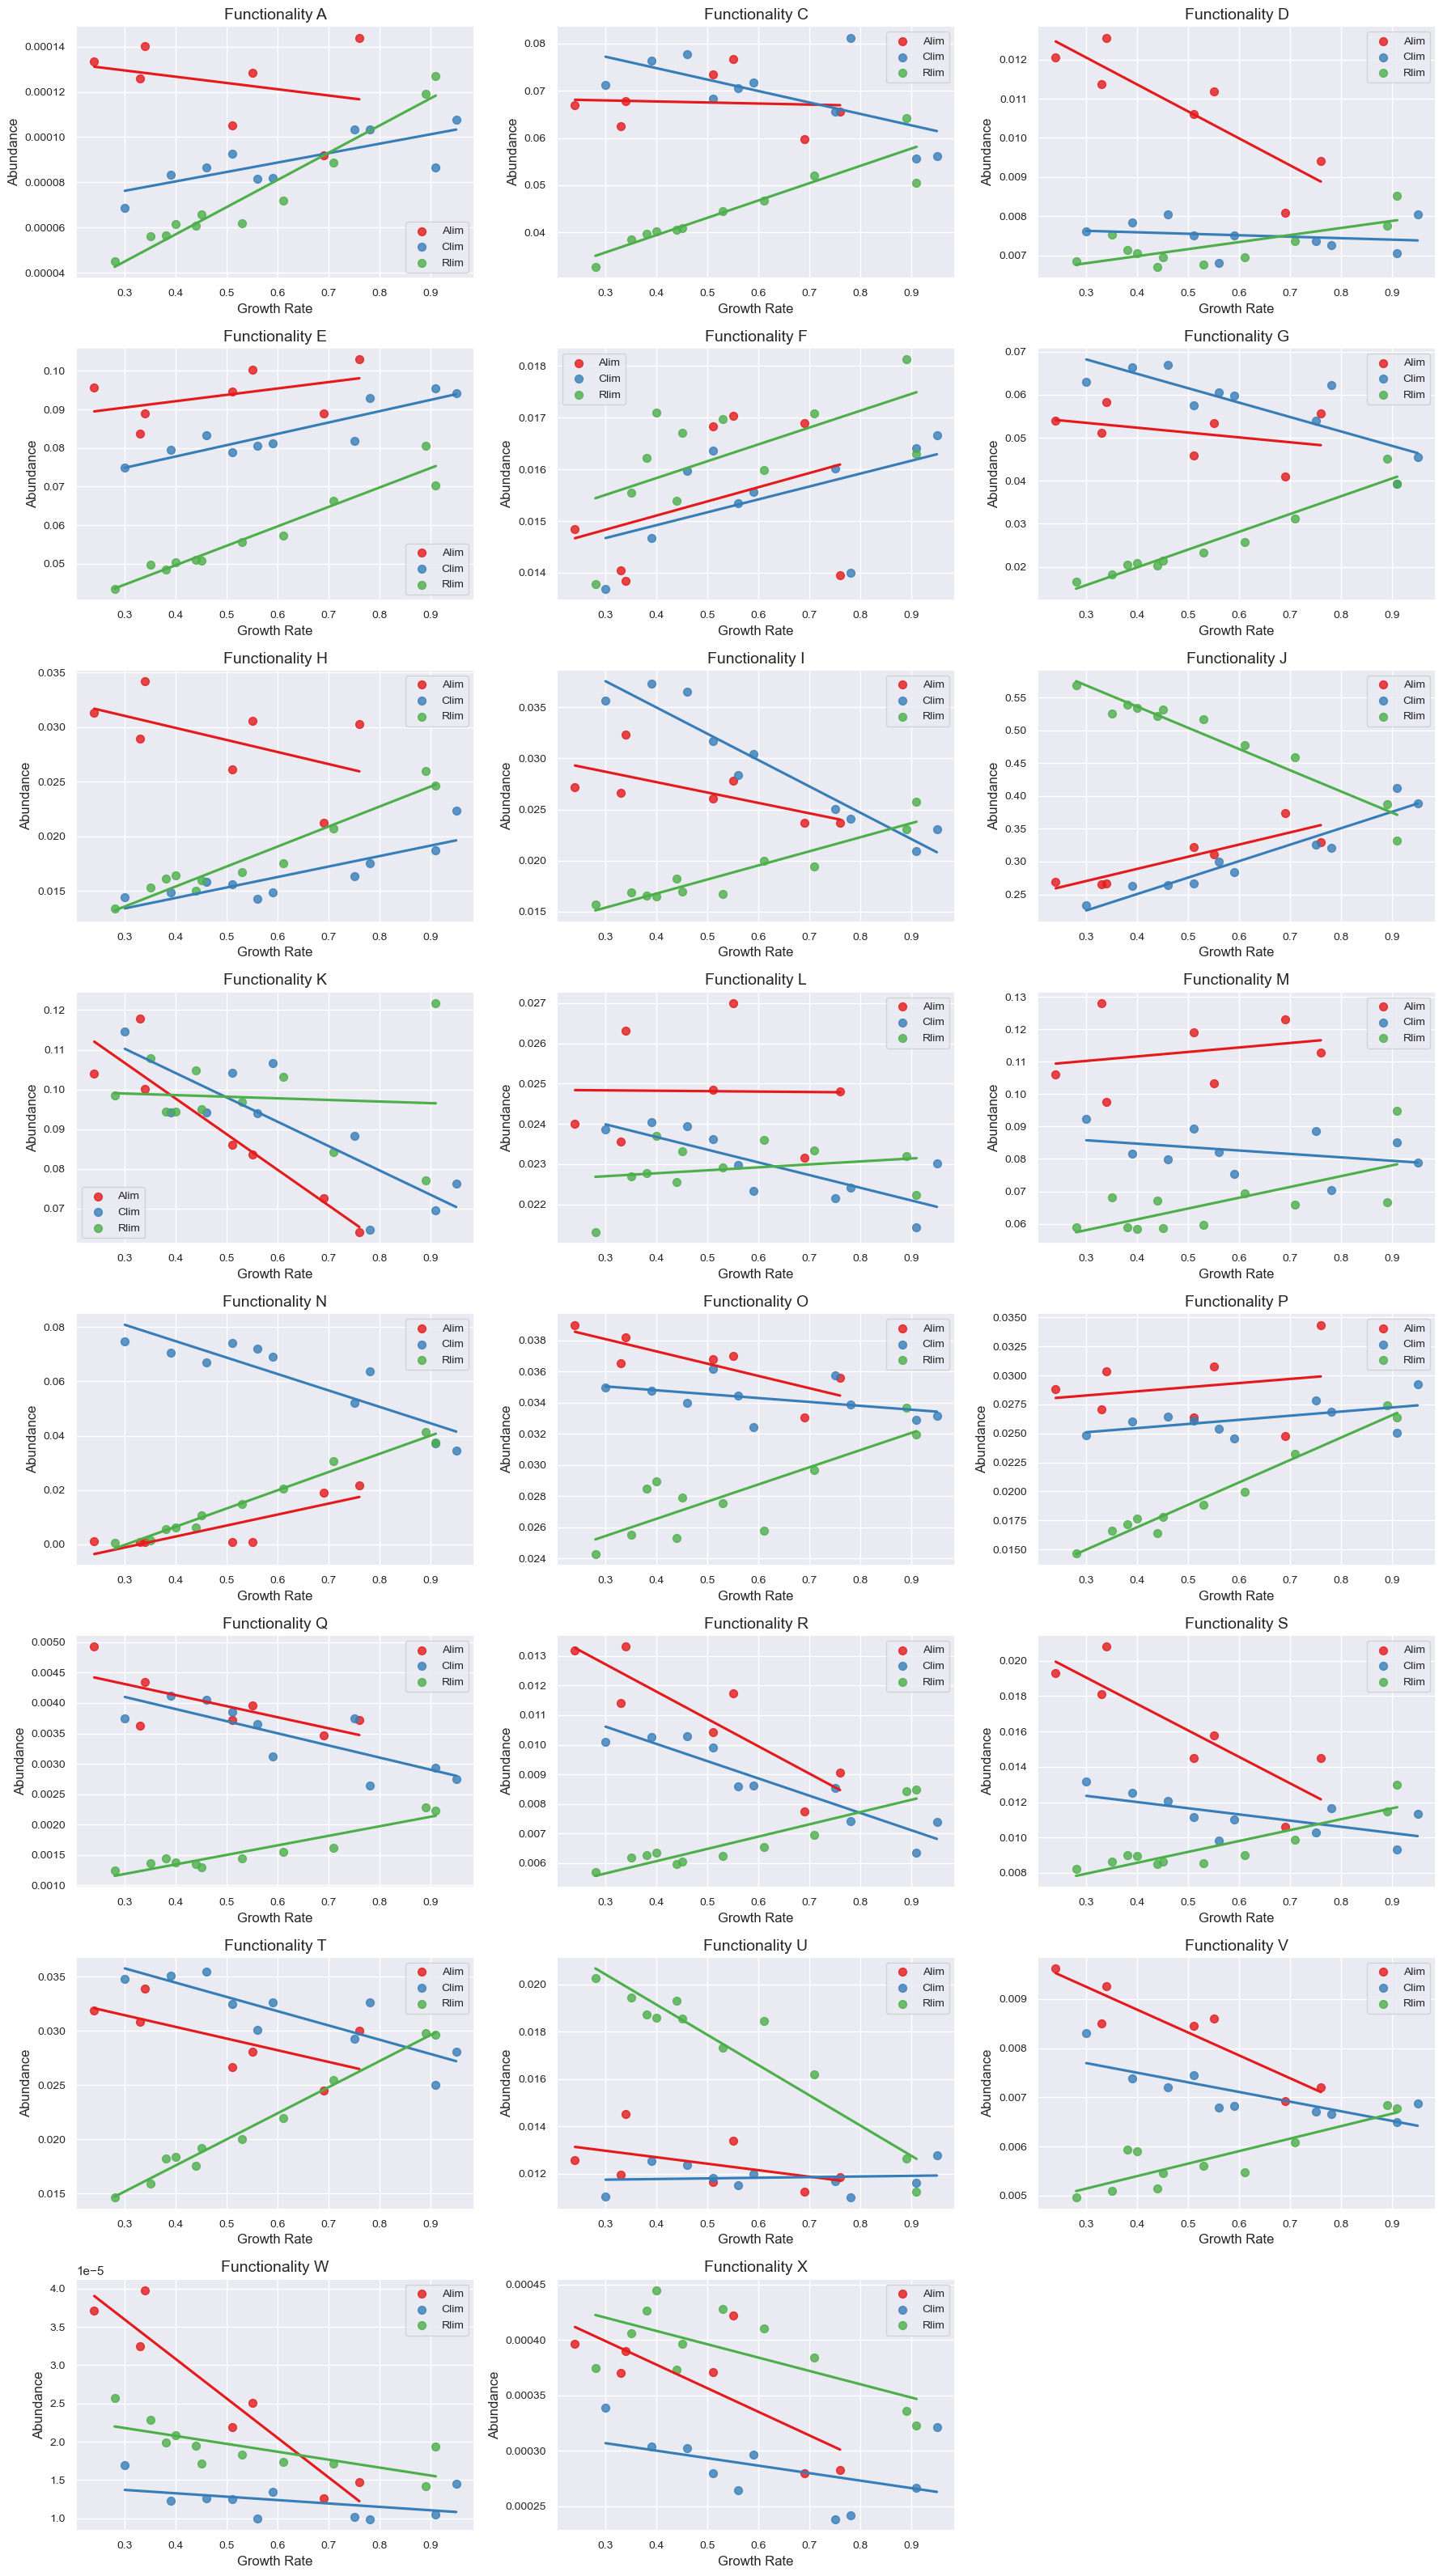

In [50]:
plot_join_sep_by_func()

### Discussion

Theoretical we expect the following behaviour for the slope $m$ of the fractions $\phi_R$, $\phi_C$, $\phi_A$, $\phi_Q$ in the experimental conditions **Alim**, **Clim** or **Rlim**:
$$
\begin{array}{|c|c|c|c|}
\hline
 & C\text{-}lim & A\text{-}lim & R\text{-}lim \\
\hline
m>0 & R,A & R, C &  A,C\\
\hline
m=0 & Q & Q & Q \\
\hline
m<0 & C & A & R \\
\hline
\end{array}
$$

Of course in real data we need to choose a threshold $m_t$ above which we consider the slope to be significantly different from 0. This value seems, for the moment, completely arbitrary, also because different functional group can have intrinsically different typical abundances and this should not affect their classification. Looking at the presented plot we try $m_t = 0.008$ which seems a reasonable choice. In the following we carry out the categorization accordingly.

In [72]:
data1 = {'Alim': [None , None, None],
        "Clim": [None ,None , None],
        'Rlim': [None, None, None]}

#treshold_max = 0.001
#treshold_min = -0.0005

treshold_max = 0.008
treshold_min = -0.008

In [73]:
Rlim_dic = list(RTcog_func_by_functionality.keys())

mayores= ''
menores= ''
iguales= ''
for key in Rlim_dic:
    data = RTcog_func_by_functionality[key]

    slope = (np.polyfit(data['Growth.rate..1.h.'], data['Gene.sum'], 1)[0])
    #print(key, slope)

    if slope > treshold_max:
        mayores = mayores + key[-1]
        data1['Rlim'][0] = mayores
    elif slope < treshold_min:
        menores  = menores + key[-1]
        data1['Rlim'][2] = menores
    else :
        iguales = iguales + key[-1]
        data1['Rlim'][1] = iguales

In [74]:
Clim_dic = list(CTcog_func_by_functionality.keys())

mayores= ''
menores= ''
iguales= ''
for key in Clim_dic:
    data = CTcog_func_by_functionality[key]

    slope = (np.polyfit(data['Growth.rate..1.h.'], data['Gene.sum'], 1)[0])
    #print(key, slope)

    if slope > treshold_max:
        mayores = mayores + key[-1]
        data1['Clim'][0] = mayores
    elif slope < treshold_min:
        menores  = menores + key[-1]
        data1['Clim'][2] = menores
    else :
        iguales = iguales + key[-1]
        data1['Clim'][1] = iguales

In [82]:
Alim_dic = list(ATcog_func_by_functionality.keys())
mayores= ''
menores= ''
iguales= ''

for key in Alim_dic:
    data = ATcog_func_by_functionality[key]

    slope = (np.polyfit(data['Growth.rate..1.h.'], data['Gene.sum'], 1)[0])
    #print(key, slope)

    if slope > treshold_max:
        mayores = mayores + key[-1]
        data1['Alim'][0] = mayores
    elif slope < treshold_min:
        menores  = menores + key[-1]
        data1['Alim'][2] = menores
    else :
        iguales = iguales + key[-1]
        data1['Alim'][1] = iguales

In [76]:
cat_list = []
anal_list = []
ribo_list = []
q_list= []
both_list = []

In [77]:
Rlim_dic = list(RTcog_func_by_functionality.keys())
for funcional in Rlim_dic:
  fun = funcional[-1]
  # q classify
  if fun in data1["Alim"][1] and fun in data1['Clim'][1] and fun in data1['Rlim'][1]:
    q_list.append(fun)
  # rlim classify
  elif fun in data1["Alim"][0] and fun in data1['Clim'][0] and fun in data1['Rlim'][2]:
    ribo_list.append(fun)
    # anal classify
  elif fun in data1["Alim"][2] and fun in data1['Clim'][0] and fun in data1['Rlim'][0]:
    anal_list.append(fun)
    #cat classify
  elif fun in data1["Alim"][0] and fun in data1['Clim'][2] and fun in data1['Rlim'][0]:
    cat_list.append(fun)
  else:
    both_list.append(fun)

In [85]:
table_latex = r"""$$
\begin{array}{|c|c|c|c|}
\hline
 & C\lim & A\lim & R\lim \\
\hline
m>0 & """ + str(data1["Clim"][0]) + r""" & """ + str(data1["Alim"][0]) + r""" & """ + str(data1["Rlim"][0]) + r""" \\
\hline
m=0 & """ + str(data1["Clim"][1]) + r""" & """ + str(data1["Alim"][1]) + r""" & """ + str(data1["Rlim"][1]) + r""" \\
\hline
m<0 & """ + str(data1["Clim"][2]) + r""" & """ + str(data1["Alim"][2]) + r""" & """ + str(data1["Rlim"][2]) + r""" \\
\hline
\end{array}
$$"""

from IPython.display import display, Markdown
display(Markdown(table_latex))

$$
\begin{array}{|c|c|c|c|}
\hline
 & C\lim & A\lim & R\lim \\
\hline
m>0 & EHJ & EJMN & CEGHIMNOPT \\
\hline
m=0 & ADFLOPQRSUVWX & ACDFLOPQUVWX & ADFKLQRSVWX \\
\hline
m<0 & CGIKMNT & GHIKRST & JU \\
\hline
\end{array}
$$

Invariant fraction:  ['A', 'D', 'F', 'L', 'Q', 'V', 'W', 'X']
Ribosome fraction:  ['J']
Anabolic fraction:  ['H']
Catabolic fraction:  ['M', 'N']
Multiples fraction:  ['C', 'E', 'G', 'I', 'K', 'O', 'P', 'R', 'S', 'T', 'U']


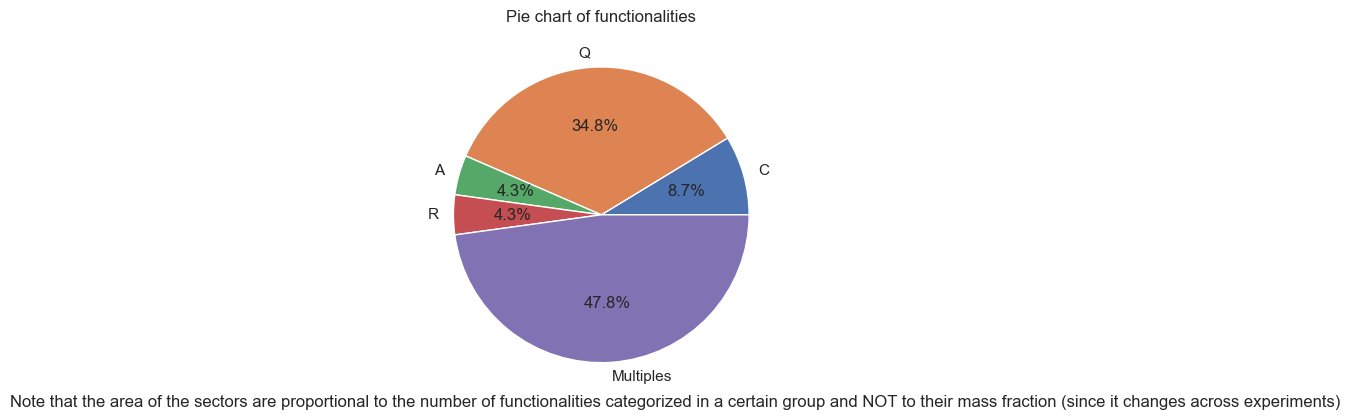

In [91]:
print('Invariant fraction: ',q_list)
print('Ribosome fraction: ',ribo_list)
print('Anabolic fraction: ',anal_list)
print('Catabolic fraction: ',cat_list)
print('Multiples fraction: ',both_list)

data_dict = {
    "cat_list": cat_list,
    "q_list": q_list,
    "anal_list": anal_list,
    "ribo_list": ribo_list,
    "both_list": both_list
}

df = pd.DataFrame({ col: pd.Series(vals) for col, vals in data_dict.items() })

list_counts = {
    'C':  len(cat_list),
    'Q':    len(q_list),
    'A': len(anal_list),
    'R': len(ribo_list),
    'Multiples': len(both_list)
}

df_counts = pd.DataFrame.from_dict(list_counts, 
                                   orient='index', 
                                   columns=['Count'])
ax = df_counts.plot(
    kind='pie',      
    y='Count',        
    autopct='%1.1f%%', 
    legend=False,
    ylabel=''          
)
ax.set_title('Pie chart of functionalities')
ax.text(0.5, -1.3, "Note that the area of the sectors are proportional to the number of functionalities categorized in a certain group and NOT to their mass fraction (since it changes across experiments)", 
            ha='center', fontsize=12)
plt.show()

By comparing the predictions with the results we can clearly identify $J$ as the only functional category that is consistent with the class $R$ in all the three experimental settings. Indeed, $J$ is described as related to  "Translation, ribosomal structure and biogenesis" so our conclusions seems reasonable. \
Then we see that functionalities $M$ and $N$ are the only one consistent with class C so we conclude that they should be catabolic proteins. Analogously functionality $H$ should be anabolic. 
Additionally, the abundance of functionalities $A$, $D$, $F$, $L$, $Q$, $V$, $W$, $X$ is found to be indipendent of the growth rate in all experimental settings, so we classify them as belonging to class Q.
This classification fails to categorize some functionalities (enlisted as `Multiples`) that act as a group (catabolic/anabolic/invariant) in one experimental setting (Alim, Clim, Rlim) and as an another group in another experimental condition, a behavior that the model is not able to account for but is biologically possible when proteins interact differently in presence of different substrates, which is the case switching from C-lim, to A-lim, to R-lim. \
We try in the following a different categorization approach that does not require the choice of any arbitrary parameter.

### PCA and clustering

Our previous analysis could be carried out replacing the slope $m$ with the Pearson correlation coefficient that has the advantage of measuring how good the linear approximation is for a set of data, irrespectively of the scale of variation on the y-axis. In the following we have attempted to categorize functionalities using a clustering algorithm (kMeans) on datapoints that take into account both the slopes and the correlations coefficients. \
By applying Principal Component Analysis (PCA) to our six-dimensional data (slope and correlation values from three experimental settings Alim, Clim, Rlim for each functional group $\alpha$), we are performing a linear transformation that finds new axes in the data space—called principal components (PCs)—which maximize variance. Instead of simply selecting two of the six original variables, PCA constructs two new dimensions as linear combinations of all six, ensuring they capture the most important patterns in the data. These PCA components represent the directions in which our data varies the most, allowing us to reduce dimensionality while preserving key structural relationships. This transformation is particularly useful to understand the results of clustering, as it helps to visualize and separate data points in a lower-dimensional space while maintaining the essential differences between groups.

In [79]:
import pandas as pd
import numpy as np

# Cargar los CSV de cada experimento
df_A = pd.read_csv('A_lim_functionalities.csv')
df_C = pd.read_csv('C_lim_functionalities.csv')
df_R = pd.read_csv('R_lim_functionalities.csv')
# Función para calcular pendiente y correlación para cada categoría funcional en un dataset
def calc_stats(df, prefix):
    results = []
    for cat in sorted(df['Source'].unique()):
        if not cat.startswith(prefix):
            continue
        sub = df[df['Source'] == cat]
        x = sub['Growth'].values       # tasa de crecimiento
        y = sub['Gene_Sum'].values    # fracción proteica de la categoría
        if len(x) < 2:
            continue
        # Pendiente de la recta ajuste lineal y correlación de Pearson
        slope = np.polyfit(x, y, 1)[0]
        corr = np.corrcoef(x, y)[0, 1]
        results.append({
            'Categoria': cat.split('_')[1],
            f'slope_{prefix}': slope,
            f'corr_{prefix}': corr
        })
    return pd.DataFrame(results)

# Calcular para cada experimento
stats_A = calc_stats(df_A, 'Alim')
stats_C = calc_stats(df_C, 'Clim')
stats_R = calc_stats(df_R, 'Rlim')

# Unir resultados en un solo DataFrame
stats = stats_A.merge(stats_C, on="Categoria").merge(stats_R, on="Categoria")


In [80]:
from sklearn.cluster import KMeans

# Seleccionar las características: pendientes y correlaciones en cada experimento
X = stats[['slope_Alim','slope_Clim','slope_Rlim','corr_Alim','corr_Clim','corr_Rlim']].values

# Aplicar K-Means con k=4
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)
stats['Cluster'] = kmeans.labels_

# Ver resultados: agrupación de algunas categorías por cluster
for cl in range(4):
    cats = stats[stats.Cluster==cl]['Categoria'].tolist()
    print(f"Cluster {cl}: {cats}")
stats

Cluster 0: ['J']
Cluster 1: ['C', 'D', 'G', 'I', 'L', 'M', 'N', 'O', 'Q', 'R', 'S', 'T', 'V']
Cluster 2: ['A', 'E', 'F', 'H', 'P']
Cluster 3: ['K', 'U', 'W', 'X']


C:\Users\ymamani\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Categoria,slope_Alim,corr_Alim,slope_Clim,corr_Clim,slope_Rlim,corr_Rlim,Cluster
0,A,-0.000028,-0.284180,0.000042,0.747100,0.000120,0.970412,2
1,C,-0.002203,-0.072594,-0.024198,-0.625993,0.036626,0.918701,1
2,D,-0.006883,-0.864993,-0.000376,-0.204805,0.001802,0.721010,1
3,E,0.016519,0.472596,0.029363,0.892828,0.050399,0.966016,2
4,F,0.002738,0.354492,0.002491,0.527636,0.003252,0.611122,2
5,G,-0.011288,-0.368148,-0.033514,-0.820648,0.041345,0.969688,1
6,H,-0.011028,-0.513452,0.009579,0.842871,0.018298,0.965766,2
7,I,-0.010167,-0.676091,-0.025745,-0.948512,0.013781,0.935903,1
8,J,0.185078,0.881261,0.250546,0.955858,-0.323001,-0.963485,0
9,K,-0.089741,-0.932449,-0.061283,-0.826444,-0.004036,-0.073256,3


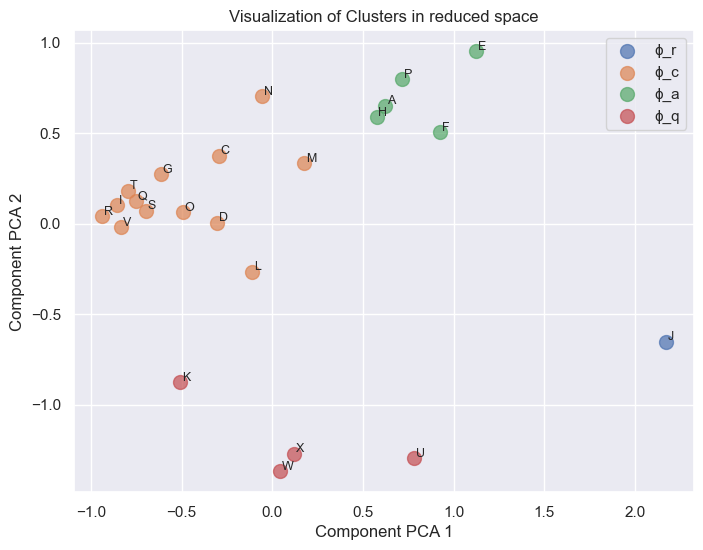

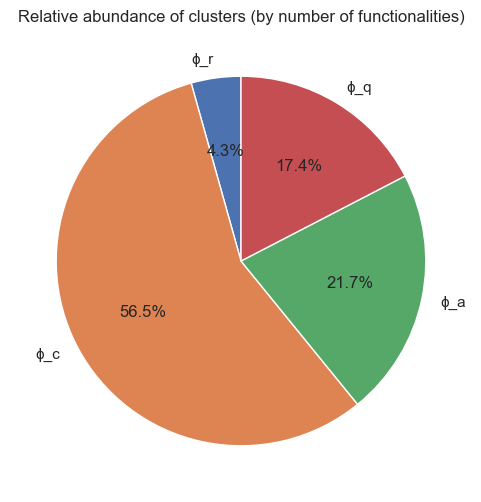

In [92]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Definir el diccionario de mapeo: se asume que los clusters son 0, 1, 2 y 3
cluster_nombres = {0: "ϕ_r", 1: "ϕ_c", 2: "ϕ_a", 3: "ϕ_q"}

# Seleccionar las características utilizadas para clustering
X = stats[['slope_Alim','slope_Clim','slope_Rlim','corr_Alim','corr_Clim','corr_Rlim']].values

# Aplicar PCA para reducir a 2 dimensiones (para visualización)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Crear scatter plot de los clusters en el espacio PCA
plt.figure(figsize=(8,6))
for cl in np.unique(stats['Cluster']):
    # Seleccionar los índices de cada cluster
    idx = stats['Cluster'] == cl
    # Obtener el nombre correspondiente
    nombre_cluster = cluster_nombres.get(cl, f"Cluster {cl}")
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], s=100, alpha=0.7, label=nombre_cluster)

# Agregar etiquetas para cada categoría funcional
for i, cat in enumerate(stats['Categoria']):
    plt.text(X_pca[i, 0] + 0.01, X_pca[i, 1] + 0.01, cat, fontsize=9)

plt.xlabel("Component PCA 1")
plt.ylabel("Component PCA 2")
plt.title("Visualization of Clusters in reduced space")
plt.legend()
plt.show()

# Crear un gráfico de pastel (pie chart) con la distribución de los clusters
cluster_counts = stats['Cluster'].value_counts().sort_index()
# Crear las etiquetas utilizando el diccionario
labels = [cluster_nombres.get(i, f"Cluster {i}") for i in cluster_counts.index]

plt.figure(figsize=(6,6))
plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Relative abundance of clusters (by number of functionalities)")
plt.show()

The label of the clusters is done to maximize the match with previous results.  The constraint of dividing the data in four clusters visually seems to be appropriate but the outcome shows only a partial consistency with what has been found before. This could be due to the biological reason that proteins change their effectiveness based on the type of supplement provided to the cell, thus invaliding our initial assumptions on which the model is based.

### Possible extension to our analysis

We have based our classification entirely on the slope $m$ of the relations $\phi_{\alpha} \propto \lambda $ but we could extend it to the intercept $q$ of the same linear relations, with the following expected dependencies:

$$
\begin{array}{|c|c|c|c|}
\hline
 & C\text{-}lim & A\text{-}lim & R\text{-}lim \\
\hline
q>0 & C,R,Q & A,R,Q &  R,Q \\
\hline
q=0 & A & C & A,C \\
\hline
\end{array}
$$
The idea would be to see if the two classifications are consistent. \
The data would make it also possibile to estimate some constant parameters of the cell such as $\phi_{max}$ and $\phi_0$.